# Dataset Overview: Mountain Named Entity Recognition

This notebook provides an overview of the dataset creation process and analyzes the entity distribution in the Mountain NER dataset.


## Setup and Installation

In [1]:
%cd NER
!pip install -r requirements.txt

[Errno 2] No such file or directory: 'NER'
/Users/vika/PycharmProjects/Quantum/NER
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


## Dataset Creation Pipeline

The dataset is created using a three-step pipeline.


### Step 1: Sample Generation with MistralGenerator

The `MistralGenerator` class uses the Mistral 7B LLM to generate diverse sentences about mountains.

**Prerequisites:**
Before running the generator, ensure:
- **Ollama is installed and running** on your device
- **Mistral model is pulled**: Run `ollama pull mistral:7b` in terminal

**Features:**
- Uses LLM prompts to create natural sentences
- Incorporates known mountains from a reference list
- Randomly varies entity mentions (with/without "Mount", "Mountain", etc.)
- Performs validation by excluding artifacts generated by LLM (like entities with "River" in name, etc.)
- Returns samples with character-level entity positions


In [2]:
# Example

from src.dataset.generator.mistral.mistral_generator import MistralGenerator

generator = MistralGenerator()
samples = generator.generate(num_examples=3)
print(f"Generated {len(samples)} samples")
if samples:
    print("\nSample output:")
    print(f"1. Text: {samples[0].text}")
    print(f"   Entities: {[e.text for e in samples[0].entities]}")

Ollama connection successful. Using model: mistral:7b
Loaded 98 known mountains from src/dataset/static/mountains.txt
Generated 3 samples

Sample output:
1. Text: The Matterhorn, a famous mountain in Switzerland, has been a symbol of adventure for centuries.
   Entities: ['Matterhorn']


### Step 2: BIO Tagging with BioTagger

The `BioTagger` class converts entity character spans to BIO (Begin-Inside-Outside) tagging format.

**BIO Format:**
- `B-MOUNTAIN`: Beginning of a mountain name
- `I-MOUNTAIN`: Inside/continuation of a mountain name
- `O`: Outside - not a mountain name

In [3]:
# Example

from NER.src.dataset.tagger.bio.bio_tagger import BioTagger

tagger = BioTagger()
tagged = tagger.tag(samples)[0]

print(f"Original text: {tagged.text}")
print(f"BIO tags: {tagged.tags}")

Original text: The Matterhorn, a famous mountain in Switzerland, has been a symbol of adventure for centuries.
BIO tags: ['O', 'B-MOUNTAIN', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Step 3: Complete Pipeline with NERDataset

The `NERDataset` class orchestrates the entire process and exports to CSV.

**Pipeline Flow:**
1. Generate samples in batches using the generator
2. Tag each batch with BIO format
3. Convert to DataFrame format
4. Save to CSV file
5. Return final DataFrame


In [4]:
# Example

from NER.src.dataset.create_dataset import NERDataset
from NER.src.dataset.generator.mistral.mistral_generator import MistralGenerator
from NER.src.dataset.tagger.bio.bio_tagger import BioTagger

pipeline = NERDataset(
    generator=MistralGenerator(),
    tagger=BioTagger(),
    output_dir="results/data"
)

df = pipeline.run(
    num_samples=5,
    save_to_csv=False,
)

print(f"Generated {len(df)} samples")
print(df.head())

Ollama connection successful. Using model: mistral:7b
Loaded 98 known mountains from src/dataset/static/mountains.txt
Starting pipeline for 5 samples...


Processing batches: 100%|██████████| 1/1 [00:24<00:00, 24.73s/batch]

Pipeline completed. Generated 4 samples.
Generated 4 samples
                                                text  \
0  The majestic Mount Fuji, Japan's highest mount...   
1  The Matterhorn, a distinctive peak in the Swis...   
2  Mount Aconcagua, towering at 6,962 meters abov...   
3  The breathtaking Mount Rushmore, located in th...   

                                                tags         entities  
0      O O B-MOUNTAIN I-MOUNTAIN O O O O O O O O O O       Mount Fuji  
1         O B-MOUNTAIN O O O O O O O O O O O O O O O       Matterhorn  
2  B-MOUNTAIN I-MOUNTAIN O O O O O O O O O O O O ...  Mount Aconcagua  
3  O O B-MOUNTAIN I-MOUNTAIN O O O O O O O O O O ...   Mount Rushmore  


### Command Line Usage

The dataset can also be created from the command line.


In [5]:
# If not in NER directory
# %cd NER

!python src/dataset/create_dataset.py --samples 5

Ollama connection successful. Using model: mistral:7b
Loaded 98 known mountains from src/dataset/static/mountains.txt
Starting pipeline for 5 samples...
Processing batches: 100%|██████████████████████| 1/1 [00:07<00:00,  7.26s/batch]
Dataset saved to: results/data/ner_dataset_20251028_151632.csv
Pipeline completed. Generated 5 samples.
Generated dataset shape: (5, 3)
                                                text  ...           entities
0  The majestic Aoraki/Mount Cook stands tall as ...  ...  Aoraki/Mount Cook
1  The stunning Matterhorn, known for its unique ...  ...         Matterhorn
2  Fuji, an active stratovolcano, is Japan's high...  ...               Fuji
3  The Grand Teton, part of the Rocky Mountains, ...  ...        Grand Teton
4  Elbrus, the highest peak in Europe, straddles ...  ...             Elbrus

[5 rows x 3 columns]


# Dataset Overview

Overview of created datasets for training/evaluation and inference.
Dataset contains such columns:
- **text** - generated sentence
- **tags** - BIO tags for the sentence
- **entities** - list of entities in the sentence

In [6]:
import pandas as pd

df = pd.read_csv('results/data/train_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"First few rows:")
df.head(6)


Dataset Shape: (3000, 3)
First few rows:


,text,tags,entities
0,"The Matterhorn, located on the border of Switz...",O B-MOUNTAIN O O O O O O O O O O O O O O O,Matterhorn
1,Aoraki/Mount Cook is New Zealand's highest mou...,B-MOUNTAIN I-MOUNTAIN O O O O O O O O O O O,Aoraki/Mount Cook
2,"Fuji, Japan's tallest mountain, is a symbol of...",B-MOUNTAIN O O O O O O O O O O O O,Fuji
3,"Mount Vesuvius, famous for its eruption that d...",B-MOUNTAIN I-MOUNTAIN O O O O O O O O O O O O O,Mount Vesuvius
4,"Mount Elbrus, located in Russia, is the highes...",B-MOUNTAIN I-MOUNTAIN O O O O O O O O O,Mount Elbrus
5,"Olympus, considered the home of the Greek gods...",B-MOUNTAIN O O O O O O O O O O O O O,Olympus


Created datasets shapes

In [7]:
df_train = pd.read_csv('results/data/train_dataset.csv')
df_test = pd.read_csv('results/data/test_dataset.csv')
df_inference = pd.read_csv('results/data/inference_dataset.csv')

print(f"Train dataset Shape: {df_train.shape}")
print(f"Test dataset Shape: {df_test.shape}")
print(f"Inference dataset Shape: {df_inference.shape}")

Train dataset Shape: (3000, 3)
Test dataset Shape: (983, 3)
Inference dataset Shape: (197, 3)


## Dataset Statistics


In [8]:
print("DATASET STATISTICS FOR TRAIN")
print(f"Total samples: {len(df_train):,}")
print(f"Total columns: {len(df_train.columns)}")

print(f"\nEntity statistics:")
df_train['num_entities'] = df_train['entities'].str.split().str.len()
print(f"Average entities per sample: {df_train['num_entities'].mean():.2f}")
print(f"Max entities per sample: {df_train['num_entities'].max()}")
print(f"Min entities per sample: {df_train['num_entities'].min()}")


DATASET STATISTICS FOR TRAIN
Total samples: 3,000
Total columns: 3

Entity statistics:
Average entities per sample: 1.46
Max entities per sample: 5
Min entities per sample: 1


## Entity Distribution Analysis


BIO Tag Distribution:
O             37414
B-MOUNTAIN     3000
I-MOUNTAIN     1382
Name: count, dtype: int64

Total tokens tagged: 41796


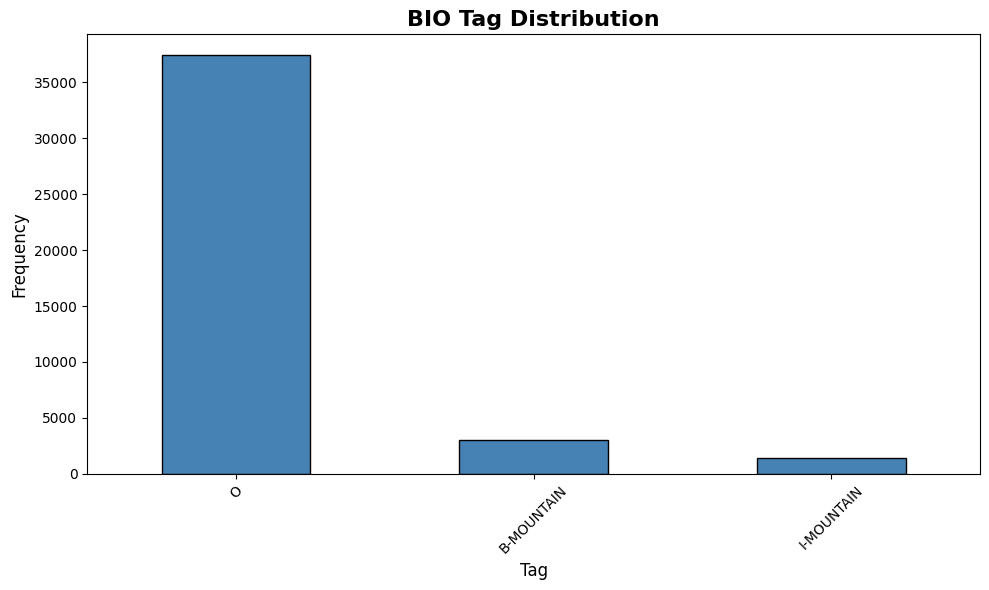

In [9]:
import matplotlib.pyplot as plt

def analyze_tag_distribution(df):
    all_tags = []
    for tags in df['tags']:
        all_tags.extend(str(tags).split())

    tag_counts = pd.Series(all_tags).value_counts()
    return tag_counts

tag_dist = analyze_tag_distribution(df)

print("BIO Tag Distribution:")
print(tag_dist)
print("\nTotal tokens tagged:", tag_dist.sum())

fig, ax = plt.subplots(figsize=(10, 6))
tag_dist.plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_title('BIO Tag Distribution', fontsize=16, fontweight='bold')
ax.set_xlabel('Tag', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


Total unique mountains: 115

Top 20 Most Frequent Mountains:
fuji                 308
matterhorn           302
elbrus               275
kilimanjaro          199
aconcagua            179
andes                157
aoraki/mount cook    151
olympus              136
vesuvius             130
denali               110
whitney              101
kosciuszko           101
vinson                76
ararat                62
rushmore              60
ural mountains        49
vinson massif         47
mont blanc            43
andes mountains       40
rocky mountains       39
Name: count, dtype: int64


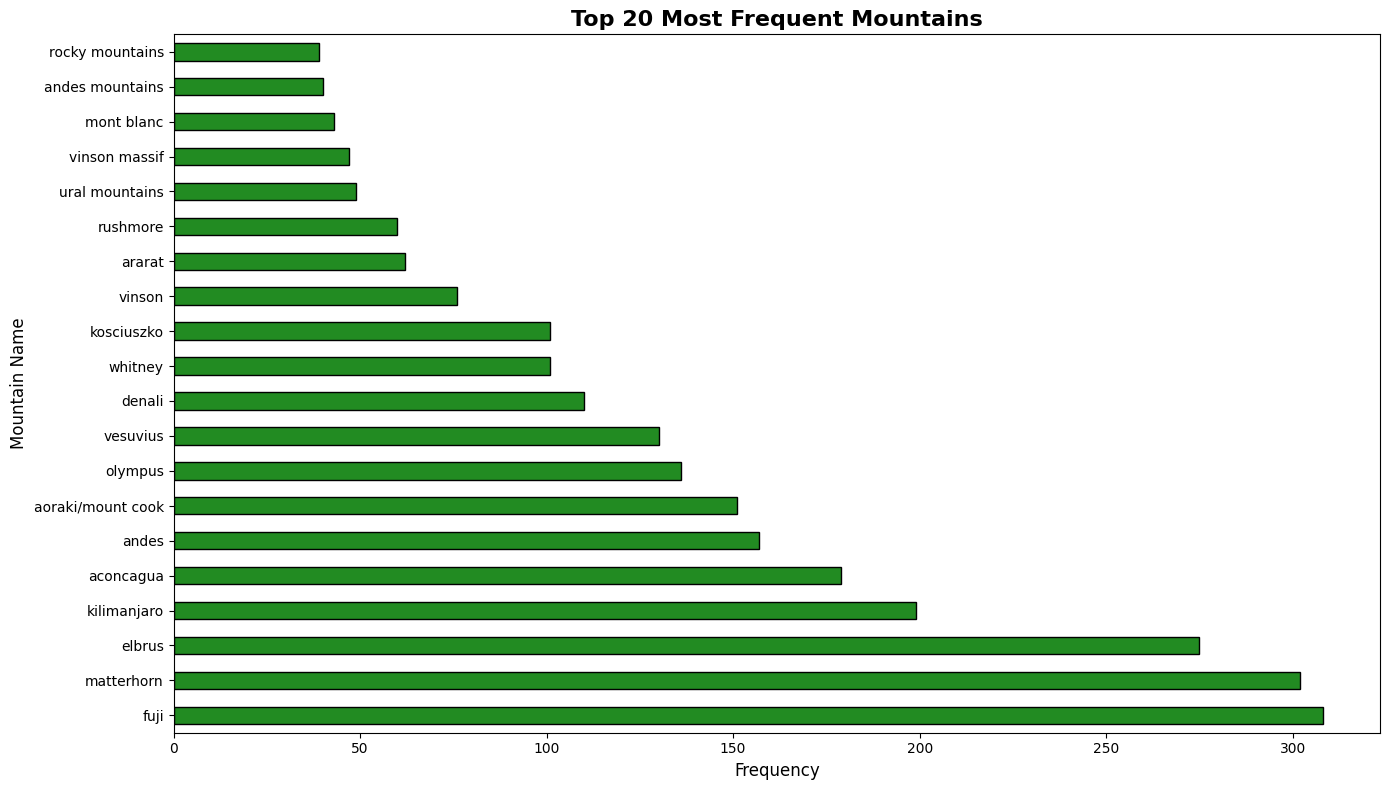

In [11]:
def normalize_entity(entity):
    if pd.isna(entity) or not entity:
        return ""

    entity = str(entity).strip().lower()

    prefixes = ["mountain", "mount", "mt", "peak", "volcano", "range"]
    for prefix in prefixes:
        if entity.startswith(prefix + ' '):
            entity = entity[len(prefix) + 1:]

    suffixes = ["mountain", "mount", "mt", "peak", "volcano", "range"]
    for suffix in suffixes:
        if entity.endswith(suffix):
            entity = entity[:-len(suffix)]

    return entity.strip()

all_entities = []
for entities in df_train['entities']:
    if pd.notna(entities):
        entity_list = str(entities).split(',')
        normalized_entities = [normalize_entity(entity) for entity in entity_list]
        all_entities.extend(normalized_entities)

all_entities = [e for e in all_entities if e]
entity_counts = pd.Series(all_entities).value_counts()

print(f"Total unique mountains: {len(entity_counts)}")
print(f"\nTop 20 Most Frequent Mountains:")
print("=" * 60)
print(entity_counts.head(20))

# Visualize top entities
fig, ax = plt.subplots(figsize=(14, 8))
top_20 = entity_counts.head(20)
top_20.plot(kind='barh', ax=ax, color='forestgreen', edgecolor='black')
ax.set_title('Top 20 Most Frequent Mountains', fontsize=16, fontweight='bold')
ax.set_xlabel('Frequency', fontsize=12)
ax.set_ylabel('Mountain Name', fontsize=12)
plt.tight_layout()
plt.show()
